In [ ]:
import tensorflow as tf
from keras import Sequential
from keras.layers import  Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img
from sklearn.metrics import confusion_matrix
from zipfile import ZipFile
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install opencv-python
import cv2

In [ ]:
# the image data set was downloaded from kaggle
# https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza?resource=download

# Download data

following lines of code depict the process of downloading the image data from the kaggle API. 

In [10]:
!pip install kaggle

In [11]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/jovyan/.kaggle’: File exists


In [13]:
#this constitutes the userename and API key to download from kaggle
os.environ["KAGGLE_USERNAME"] = "matthzoettl"
os.environ["KAGGLE_KEY"] = "8d1763ac674b849291f474464f3a77e9"
!kaggle datasets download -d carlosrunner/pizza-not-pizza

pizza-not-pizza.zip: Skipping, found more recently modified local copy (use --force to force download)


In [121]:
#this next step is only to be done once while first downloading the zip file.
file_name = "pizza-not-pizza.zip"
with ZipFile(file_name, "r") as zip:
    zip.extractall()

In [ ]:
#remove unwanted file that came with the download
os.remove("pizza_not_pizza/food101_subset.py") 

In [15]:
# followingly we will traverse through the downloaded folders and apply a label to the images.
# when an image is in the not_pizza folder it will be encoded with a 0 and the pizza folder will be encoded with a 1
img_path = []
label = []

for di in os.listdir("pizza_not_pizza"):
    for path in os.listdir("pizza_not_pizza/"+di):
        if di == "not_pizza":
            label.append("0")
        else: 
            label.append("1")
        img_path.append(os.path.join("pizza_not_pizza", di, path))
        
print(img_path[0], label[0])

pizza_not_pizza/not_pizza/1005746.jpg 0


<br>
now we will convert this into a pandas dataframe with the imagepath and the corresponding label (0=not pizza, 1=pizza)
<br>
 

In [90]:
df = pd.DataFrame()
df["img"] = img_path
df["label"] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

img label
0   pizza_not_pizza/not_pizza/320996.jpg     0
1      pizza_not_pizza/pizza/1205154.jpg     1
2  pizza_not_pizza/not_pizza/3372205.jpg     0
3      pizza_not_pizza/pizza/2101820.jpg     1
4   pizza_not_pizza/not_pizza/461582.jpg     0

## Exploratory Data Analysis

Here we try to look at the data set beforehand to get a better understanding of our images. This analysis beforehand creates a better understanding of the dataset before actually working on it.

In [37]:
# Here we create the file paths as variables for faster usage and also print out the number of pizza and non-pizza images in our dataset
pizza_dir = 'pizza_not_pizza/pizza'
not_pizza_dir = 'pizza_not_pizza/not_pizza'
data_dir = 'pizza_not_pizza'


num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))

print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')
    

Number of Pizza images: 983
Number of Non-Pizza images: 983


<AxesSubplot:xlabel='label', ylabel='count'>

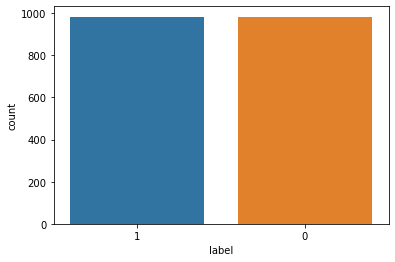

In [38]:
#Let's visualize the distribution of labels, meaning the number of pizza and not_pizza images in the form of a countplot

import seaborn as sns
sns.countplot(x=df['label'])

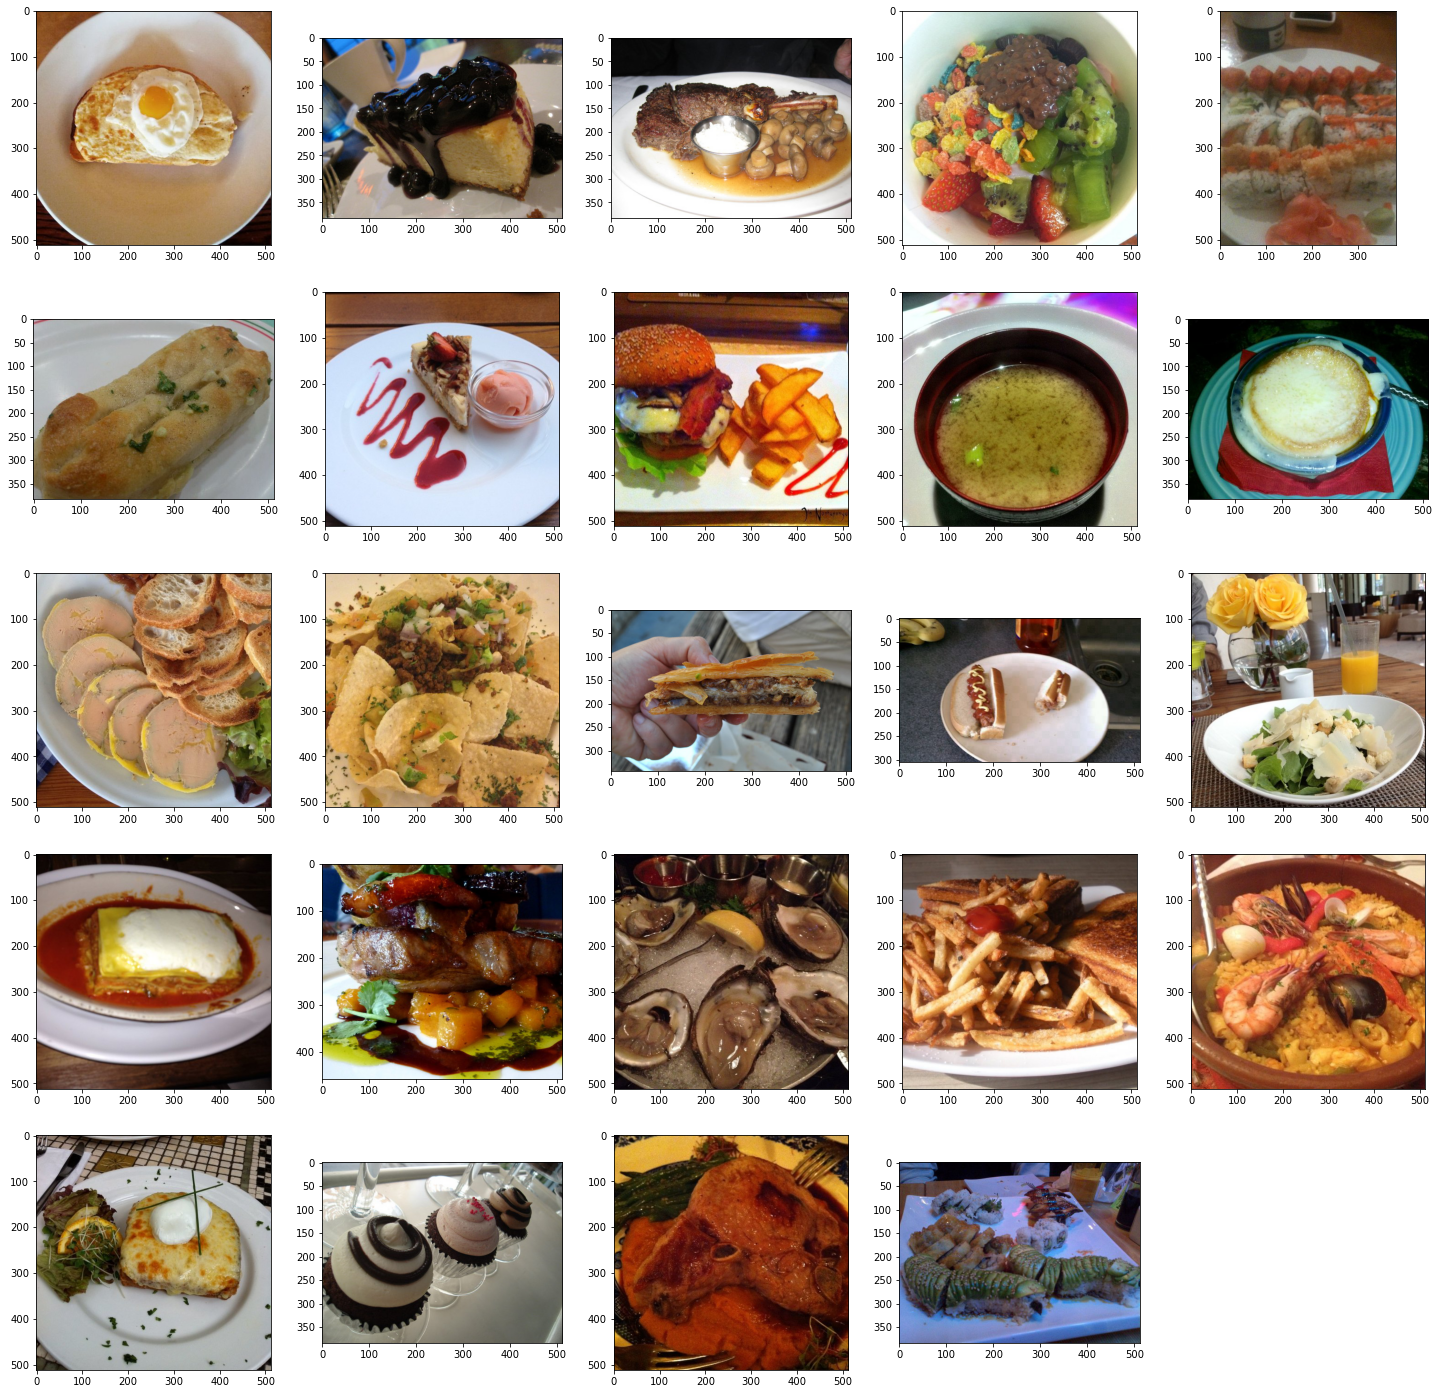

In [118]:
#lets look at some of the non pizza images in our dataset
plt.figure(figsize=(25,25))
non_pizza_imgs = df[(df.label == "0")]
paths = non_pizza_imgs[1:25]

for index, image in enumerate(paths["img"]):
    plt.subplot(5,5, index+1)
    img = plt.imread(image)
    plt.imshow(img)

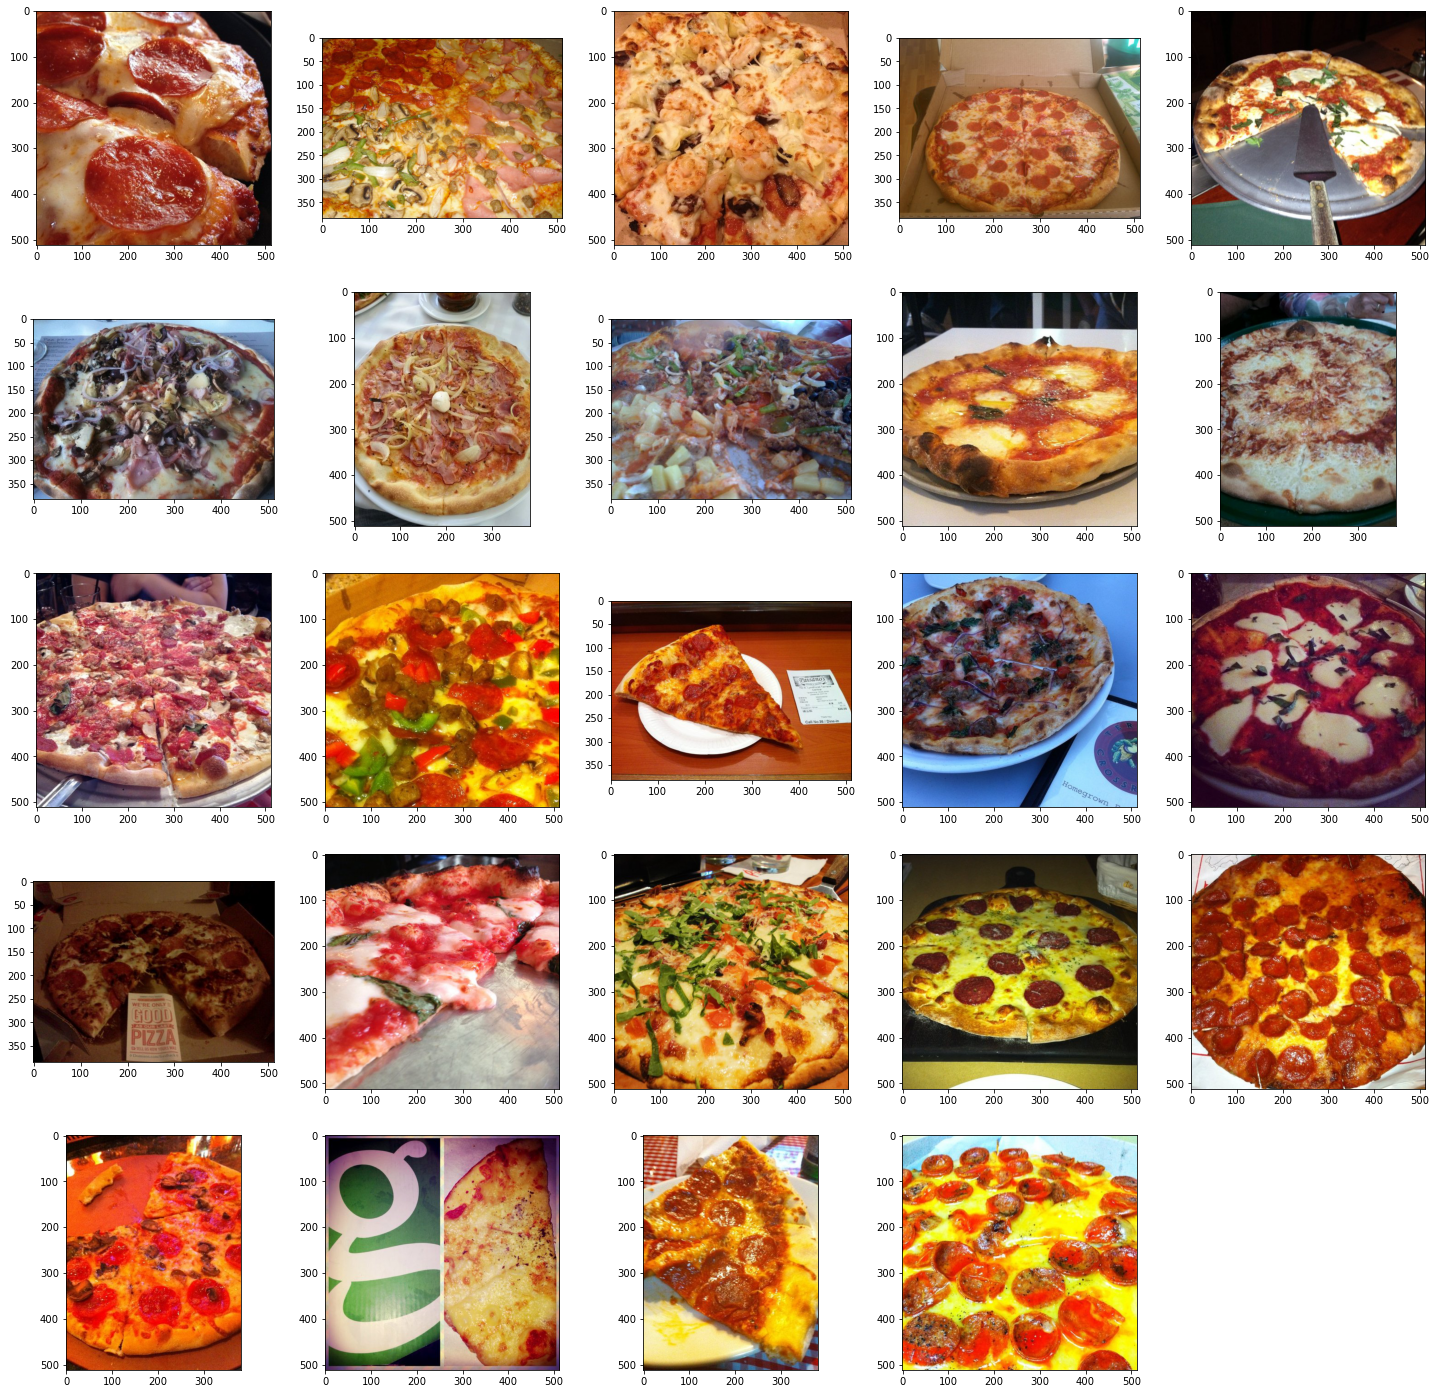

In [119]:
#lets look at some of the pizza images in our dataset
plt.figure(figsize=(25,25))
pizza_imgs = df[(df.label == "1")]
paths = pizza_imgs[1:25]

for index, image in enumerate(paths["img"]):
    plt.subplot(5,5, index+1)
    img = plt.imread(image)
    plt.imshow(img)

In [17]:
# split in test and train data
train, test = train_test_split(df, test_size=0.2, random_state=38)

In [18]:
print("Number of Images in Training batch = " + str(len(train)))
print("Number of Images in Test batch = " + str(len(test)))

Number of Images in Training batch = 1572
Number of Images in Test batch = 394


<br>
create the generator for loading the images into our model. In doing so, I'll use certain data augmentation techniques (rotation, zoom etc) to make our model more robust

In [19]:
train_generator = ImageDataGenerator (
    rescale = 1./255,
    rotation_range = 20,
    fill_mode = "nearest",
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range =  0.2,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

In [21]:
#train_generator.shape()

In [20]:
#the train_iterator loads the images with the augmentation parameters previously specified in the train_generator
train_iterator = train_generator.flow_from_dataframe(train,
                                                     x_col="img",
                                                     y_col="label",
                                                     target_size=(128, 128),
                                                     batch_size=512,
                                                     class_mode="binary",
                                                     shuffle = True,
                                                     seed = 38,
                                                     subset = "training"
)

val_iterator = train_generator.flow_from_dataframe(train,
                                                     x_col="img",
                                                     y_col="label",
                                                     target_size=(128, 128),
                                                     batch_size=512,
                                                     class_mode="binary",
                                                     shuffle = True,
                                                     seed = 38,
                                                     subset = "validation"
)


test_iterator = test_generator.flow_from_dataframe(test,
                                                   x_col="img",
                                                   y_col="label",
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode="binary",
                                                   shuffle = False,
                                                   seed = 38,
                                                   subset = "training"
)


Found 1258 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 394 validated image filenames belonging to 2 classes.


For my model I am going to use a convolutional neural network (CNN). This architecture is designed to process data with a grid-like topology, such as an image. It is composed of multiple layers of interconnected nodes, where each conv. layer is responsible for learning a set of filters that can be applied to the input data. The filters learned by the CNN are designed to detect specific patterns or features in the input data. For example, in the case of an image, the filters may be designed to detect edges, corners, or other distinctive features that are important for recognizing the objects in the image.

In particular, the layers of my model are constructed like this:  
First, I am adding a convoultional layer with 16 filters (3px*3px in size) that scan over the images. My activation for this layer will be a rectified linear function (relu) that allows to take into account non linear patterns.

The MaxPool2d pooling layer enables down sampling of the feature maps from the previous convolutional layer output by summarizing the maximum values of given 2x2 px pools/segments. This pooling step reduces the size of images by reducing the number of pixels from the output of the previous layer. One can see this in the model summary later on, where the dimension of the previous conv. layer is always twice as big in size as the following 2x2 Pooling layer.
This is used to safe on computational cost and to extract the most important features of the given image.

In the model, I make use of 3 convolutional layers and 3 (max) pooling layers.
The flatten layer converts the prevoious output into a single one-dimensional vector, that can be used as input for a dense layer. The final dense layer of our model maps the the previous vector values to the output classes and assigns a corresponding probability. So it is either 1 (depicted image is a pizza) or 0 (depicted image is not a pizza) 

In [21]:

model = Sequential()
model.add(Conv2D(16, (3,3), activation="relu", input_shape = (128, 128, 3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense (512, activation= "relu"))
model.add(Dense(1, activation="sigmoid"))

2022-12-31 08:29:49.848358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-31 08:29:49.848450: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-31 08:29:49.848509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-h11713294-master): /proc/driver/nvidia/version does not exist
2022-12-31 08:29:49.849248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [25]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator)

Epoch 1/50
3/3 [==============================] - 39s 13s/step - loss: 1.0092 - accuracy: 0.5000 - val_loss: 0.9780 - val_accuracy: 0.4777
Epoch 2/50
3/3 [==============================] - 31s 13s/step - loss: 0.7492 - accuracy: 0.5612 - val_loss: 0.6790 - val_accuracy: 0.5318
Epoch 3/50
3/3 [==============================] - 31s 10s/step - loss: 0.6869 - accuracy: 0.4984 - val_loss: 0.6857 - val_accuracy: 0.5223
Epoch 4/50
3/3 [==============================] - 32s 10s/step - loss: 0.6897 - accuracy: 0.4976 - val_loss: 0.6811 - val_accuracy: 0.5191
Epoch 5/50
3/3 [==============================] - 31s 10s/step - loss: 0.6788 - accuracy: 0.5819 - val_loss: 0.6703 - val_accuracy: 0.6529
Epoch 6/50
3/3 [==============================] - 31s 10s/step - loss: 0.6686 - accuracy: 0.6351 - val_loss: 0.6499 - val_accuracy: 0.6783
Epoch 7/50
3/3 [==============================] - 32s 10s/step - loss: 0.6511 - accuracy: 0.6359 - val_loss: 0.6315 - val_accuracy: 0.6369
Epoch 8/50
3/3 [===========

In [27]:
result = model.evaluate(test_iterator)

13/13 [==============================] - 3s 227ms/step - loss: 0.4490 - accuracy: 0.7944


As it can be seen in the next cell, our model accuracy is about 79% and is thus undoubtedly better than random guessing

In [72]:
print("Test Accuracy:{:.2f}".format(result[1]))

Test Accuracy:0.79


In [55]:
predictions = (model.predict(test_iterator) >= 0.5).astype(np.int)                    

13/13 [==============================] - 3s 217ms/step


/tmp/ipykernel_52/1561922454.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_iterator) >= 0.5).astype(np.int)


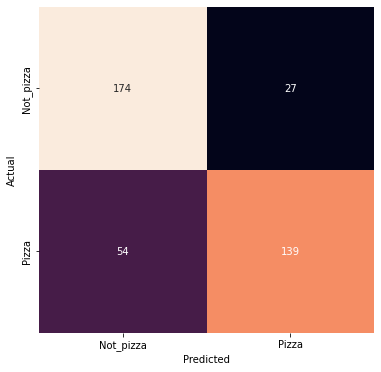

In [70]:
#now I'll create a confusion matrix 

conf_matrix = confusion_matrix(test_iterator.labels, predictions, labels=[0, 1])

plt.figure(figsize = (6,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Not_pizza', 'Pizza'])
plt.yticks(ticks = [0.5, 1.5], labels = ['Not_pizza', 'Pizza'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Out of all the non-pizza images in the training set 174 were classified correctly as not being a pizza. And 139 actual pizzas images were identified as such. 